In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load data
- I'm using the files that were updated at **April 21st**
- ref : https://github.com/jihoo-kim/Data-Science-for-COVID-19

In [2]:
# files were updated at 
PatientInfo_df = pd.read_csv('../dataset/Patient/PatientInfo.csv')
print(PatientInfo_df.shape)
PatientInfo_df.head(3)

(3326, 18)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released


In [3]:
PatientInfo_df = PatientInfo_df[PatientInfo_df.state.isin(['released', 'deceased'])]
print(PatientInfo_df.shape)
PatientInfo_df.head(3)

(1704, 18)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released


## 2. Save patient_id list
- I will add the data that will be updated after April 21st to test dataset. It's important that the present dataset(train-val-test) are separated from new dataset in the future. Therefore, it's better to save patient_id list from the present dataset

In [4]:
present_patients = PatientInfo_df.patient_id.astype(str).tolist()

with open('patients_id_0421.txt', 'w') as fp:
    fp.write('\n'.join(present_patients))

## 3. Preprocess data
- feature selection : 'sex', 'age', 'country', 'province', 'city', 'infection_case'
- handling nan
    - drop nan from 'sex' & 'age'
    - replace with mode in city (except for Daegu, Gwangju - replace with province)
    - replace with 'not-reported' in infection_case
- feature encoding
    - age : convert to integer (0~10) - label encoding
    - other columns : one-hot encoding

In [5]:
# feature selection
X_features = PatientInfo_df[['sex', 'age', 'country', 'province', 'city', 'infection_case']]
y_target = PatientInfo_df[['state']]
print(f'X_features.shape : {X_features.shape}')
print(f'y_target.shape : {y_target.shape}')
X_features.head(3)

X_features.shape : (1704, 6)
y_target.shape : (1704, 1)


,sex,age,country,province,city,infection_case
0,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow
1,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow
2,male,50s,Korea,Seoul,Jongno-gu,contact with patient


In [6]:
print('\n<< no of nan table (before handling) >>')
print(X_features.isna().sum())

# handling nan - sex & age
y_target = y_target[~X_features.sex.isna() & ~X_features.age.isna()]
X_features = X_features[~X_features.sex.isna() & ~X_features.age.isna()]

# handling nan - city
mode_city_list = X_features.groupby(['province', 'city'])['infection_case'].count().\
        reset_index().sort_values('infection_case', ascending=False).\
        drop_duplicates('province').reset_index(drop=True)
mode_city_dict = dict(mode_city_list[['province', 'city']].values)
mode_city_dict['Daegu'] = 'Daegu'
mode_city_dict['Gwangju'] = 'Gwangju'
X_features.loc[X_features.city.isna(), 'city'] = X_features[X_features.city.isna()].province.map( lambda x : mode_city_dict[ x ] )

# handling nan - infection_case
X_features.loc[X_features.infection_case.isna(), 'infection_case'] = 'not-reported'


print('\n<< no of nan table (after handling) >>')
print(X_features.isna().sum())


print(f'\n\nX_features.shape : {X_features.shape}')
print(f'y_target.shape : {y_target.shape}')


<< no of nan table (before handling) >>
sex                 7
age                10
country             0
province            0
city               45
infection_case    582
dtype: int64

<< no of nan table (after handling) >>
sex               0
age               0
country           0
province          0
city              0
infection_case    0
dtype: int64


X_features.shape : (1694, 6)
y_target.shape : (1694, 1)


In [7]:
# feature encoding
X_features_processed = pd.get_dummies(X_features[['sex', 'country', 'province', 'city', 'infection_case']])  # one-hot encoding
X_features_processed['age'] = X_features.age.str.replace('s','').astype(int)//10  # label encoding
display(X_features_processed.head(3))

print()

y_target_processed = pd.get_dummies(y_target)['state_released']
display(y_target_processed.head(3))

,sex_female,sex_male,country_China,country_France,country_Indonesia,country_Korea,country_Mongolia,country_Switzerland,country_Thailand,country_United States,...,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_not-reported,infection_case_overseas inflow,age
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,5


0    1
1    1
2    1
Name: state_released, dtype: uint8

## 4. Split data into train, val, test
- It's important that **labels are highly unbalanced** (only about 3% is deceased)

In [8]:
print('< Percentage of each label >')
display(y_target.state.value_counts(normalize=True) * 100)

< Percentage of each label >


released    96.044864
deceased     3.955136
Name: state, dtype: float64

- Since the dataset is quite small(1704 records), I will split the date into **7:2:1** for now (test data could be added from the next file update)
- Since the labels are highly imbalanced, it's better to use **stratified random sampling**.

In [9]:
# Get train dataset
X_train, X_val_test, y_train, y_val_test = train_test_split(X_features_processed, y_target_processed, test_size=0.3, random_state=0, stratify=y_target_processed)

# Get val & test dataset
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.33, random_state=0, stratify=y_val_test)

In [10]:
# Check the labels of each dataset
print('< Percentage of each label (Train dataset) > - size of dataset :', y_train.shape[0])
print(y_train.value_counts(normalize=True) * 100)

print('\n< Percentage of each label (Validation dataset) > - size of dataset :', y_val.shape[0])
print(y_val.value_counts(normalize=True) * 100)

print('\n< Percentage of each label (Test dataset) > - size of dataset :', y_test.shape[0])
print(y_test.value_counts(normalize=True) * 100)

< Percentage of each label (Train dataset) > - size of dataset : 1185
1    96.033755
0     3.966245
Name: state_released, dtype: float64

< Percentage of each label (Validation dataset) > - size of dataset : 341
1    96.187683
0     3.812317
Name: state_released, dtype: float64

< Percentage of each label (Test dataset) > - size of dataset : 168
1    95.833333
0     4.166667
Name: state_released, dtype: float64


## 5. Baseline model - Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,  f1_score

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)


# basic evaluation
pred = rf_clf.predict(X_val)
accuracy = accuracy_score(y_val, pred)
print(f'accuracy of basic Random Forests : {accuracy:.3f}')

accuracy of basic Random Forests : 0.974


C:\Users\student\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [12]:
# additional evaluation for binary classification
print('f1_score :', f1_score(y_val, pred))

print('\nconfusion_matrix :')
print(confusion_matrix(y_val, pred))

f1_score : 0.9864253393665159

confusion_matrix :
[[  5   8]
 [  1 327]]


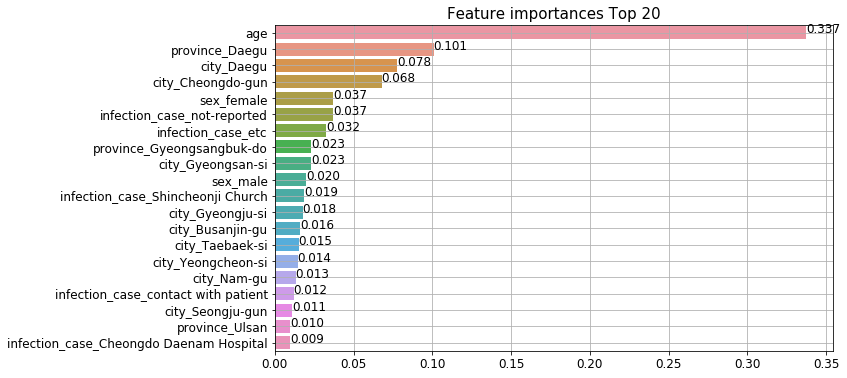

In [13]:
# get feature importnace
ftr_top20 = pd.Series(rf_clf.feature_importances_, index = X_train.columns).sort_values(ascending=False)[:20]


# visualize feature importnace
plt.figure(figsize=(10, 6))
plot = sns.barplot(ftr_top20, ftr_top20.index )
plot.set_title('Feature importances Top 20', fontsize=15)
plot.tick_params(labelsize=12)

for idx in range(ftr_top20.index.shape[0]):
    plot.text( ftr_top20[idx], idx, f'{ftr_top20[idx]:.3f}', size='large' )

plt.grid()
plt.show()